In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Attention, Dense, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


In [2]:
import os
import pandas as pd
import zipfile

# Dataset paths
dataset_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction'
train_zip_path = os.path.join(dataset_path, 'train.zip')
train_extract_path = os.path.join(dataset_path, 'train_extracted')

if not os.path.exists(train_extract_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(train_extract_path)
    print("Train data extracted.")
else:
    print("Train data already extracted.")

# Collect CSVs recursively
csv_files = []
for root, dirs, files in os.walk(train_extract_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found CSVs: {csv_files}")

# Load all CSVs
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')  # tag experiment
    dataframes.append(df)

full_train_data = pd.concat(dataframes, ignore_index=True)
print(f"Full train dataset shape: {full_train_data.shape}")


Train data already extracted.
Found CSVs: ['C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_1.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_20.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_21.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_23.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_24.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_9.csv']
Full train dataset shape: (52940, 4)


In [3]:
def create_physics_guided_sequences(df, seq_length=20):
    X, y = [], []

    input_series = df['input_voltage'].values
    output_series = df['el_power'].values

    # Feature 1: input voltage
    voltage = input_series

    # Feature 2: derivative
    derivative = np.diff(input_series, prepend=input_series[0])

    # Feature 3: time since last change
    time_since_change = np.zeros_like(input_series)
    counter = 0
    for i in range(1, len(input_series)):
        if derivative[i] == 0:
            counter += 1
        else:
            counter = 0
        time_since_change[i] = counter

    combined_input = np.vstack([voltage, derivative, time_since_change]).T

    for i in range(seq_length, len(df)):
        X.append(combined_input[i-seq_length:i])
        y.append(output_series[i])

    return np.array(X), np.array(y)

In [4]:
import numpy as np
X, y = create_physics_guided_sequences(full_train_data)

# Step 2 - Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3 - Scaling (if applicable)
scaler = MinMaxScaler()
combined_y = np.concatenate([y_train, y_test])
scaler.fit(combined_y.reshape(-1,1))
y_train_scaled = scaler.transform(y_train.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.reshape(-1,1))


In [5]:
import tensorflow.keras.backend as K

def physics_guided_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    smoothness = K.mean(K.square(y_pred[:,1:] - y_pred[:,:-1]))
    return mse + 0.01 * smoothness   # λ=0.01 is tunable

from tensorflow.keras.layers import Input, LSTM, Bidirectional, Attention, Dense, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(version="baseline", loss_fn='mse'):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    # RNN backbone
    if version in ["bilstm", "bilstm_pg", "bilstm_pg_mc"]:
        rnn_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(input_layer)
    else:
        rnn_out = LSTM(64, return_sequences=True)(input_layer)
        
    # Attention (optional)
    if version in ["attention", "bilstm", "bilstm_pg", "bilstm_pg_mc"]:
        attention_out = Attention()([rnn_out, rnn_out])
        combined = Concatenate()([rnn_out, attention_out])
    else:
        combined = rnn_out
        
    # Dense Head
    last_step = Lambda(lambda x: x[:, -1, :])(combined)
    dense_out = Dense(64 if version in ["bilstm_pg", "bilstm_pg_mc"] else 32, activation='relu')(last_step)
    
    # Dropout if physics-guided variants
    if version in ["bilstm_pg", "bilstm_pg_mc"]:
        dense_out = Dropout(0.2)(dense_out)

    output = Dense(1)(dense_out)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss_fn)
    return model

variants = ["baseline", "attention", "bilstm", "bilstm_pg", "bilstm_pg_mc"]
results = []

for v in variants:
    print(f"\nTraining Model: {v.upper()}")
    loss_function = physics_guided_loss if "pg" in v else 'mse'
    model = build_model(version=v, loss_fn=loss_function)
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0)
    
    # Evaluate
    y_pred = model.predict(X_test).flatten()
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    smoothness_penalty = np.mean(np.square(np.diff(y_pred_rescaled)))
    
    results.append({
        "Model": v,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Smoothness": smoothness_penalty
    })

results_df = pd.DataFrame(results)
results_df.to_csv(r"C:\Users\Admin\Documents\MLE\ablation_study_results.csv", index=False)
print(results_df)



Training Model: BASELINE


331/331 [==============================] - 8s 15ms/step

Training Model: ATTENTION
331/331 [==============================] - 5s 11ms/step

Training Model: BILSTM
331/331 [==============================] - 11s 23ms/step

Training Model: BILSTM_PG
331/331 [==============================] - 11s 22ms/step

Training Model: BILSTM_PG_MC
331/331 [==============================] - 17s 25ms/step
          Model          RMSE            MAE        R2    Smoothness
0      baseline  4.565523e+05  277560.391647  0.926361  5.341954e+12
1     attention  4.723045e+05  276216.582009  0.921192  5.085939e+12
2        bilstm  1.128139e+06  881997.817585  0.550373  2.374781e+12
3     bilstm_pg  1.158008e+06  971987.206485  0.526249  1.535888e+12
4  bilstm_pg_mc  1.069996e+06  850725.455072  0.595525  2.379129e+12


In [6]:
test_zip_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\test.zip'
test_extract_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction\test_extracted'

if not os.path.exists(test_extract_path):
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)
    print("Test data extracted.")
else:
    print("Test data already extracted.")

csv_files = []
for root, dirs, files in os.walk(test_extract_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found test CSVs: {csv_files}")

test_dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')  # tag experiment
    test_dataframes.append(df)

full_test_data = pd.concat(test_dataframes, ignore_index=True)
print(f"Full test dataset shape: {full_test_data.shape}")

Test data already extracted.
Found test CSVs: ['C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\test_extracted\\test\\ex_22.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\test_extracted\\test\\ex_4.csv']
Full test dataset shape: (18285, 4)


In [10]:
test_dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')
    test_dataframes.append(df)

full_test_data = pd.concat(test_dataframes, ignore_index=True)
print(f"Test Dataset Shape: {full_test_data.shape}")

# Create sequences
X_test_final, y_test_final = create_physics_guided_sequences(full_test_data, seq_length=20)
print("X_test_final shape:", X_test_final.shape)
print("y_test_final shape:", y_test_final.shape)


Test Dataset Shape: (18285, 4)
X_test_final shape: (18265, 20, 3)
y_test_final shape: (18265,)


In [11]:
y_test_final_scaled = scaler.transform(y_test_final.reshape(-1,1))

In [12]:
# Predict
y_pred_final = model.predict(X_test_final).flatten()

# Rescale
y_pred_final_rescaled = scaler.inverse_transform(y_pred_final.reshape(-1,1)).flatten()
y_test_final_rescaled = scaler.inverse_transform(y_test_final_scaled.reshape(-1,1)).flatten()

# Metrics
rmse_test = np.sqrt(mean_squared_error(y_test_final_rescaled, y_pred_final_rescaled))
mae_test = mean_absolute_error(y_test_final_rescaled, y_pred_final_rescaled)
r2_test = r2_score(y_test_final_rescaled, y_pred_final_rescaled)

print(f"Test RMSE: {rmse_test:.2f} W")
print(f"Test MAE: {mae_test:.2f} W")
print(f"Test R²: {r2_test:.4f}")

571/571 [==============================] - 19s 32ms/step
Test RMSE: 4215601.92 W
Test MAE: 4036709.48 W
Test R²: -27175929.9782


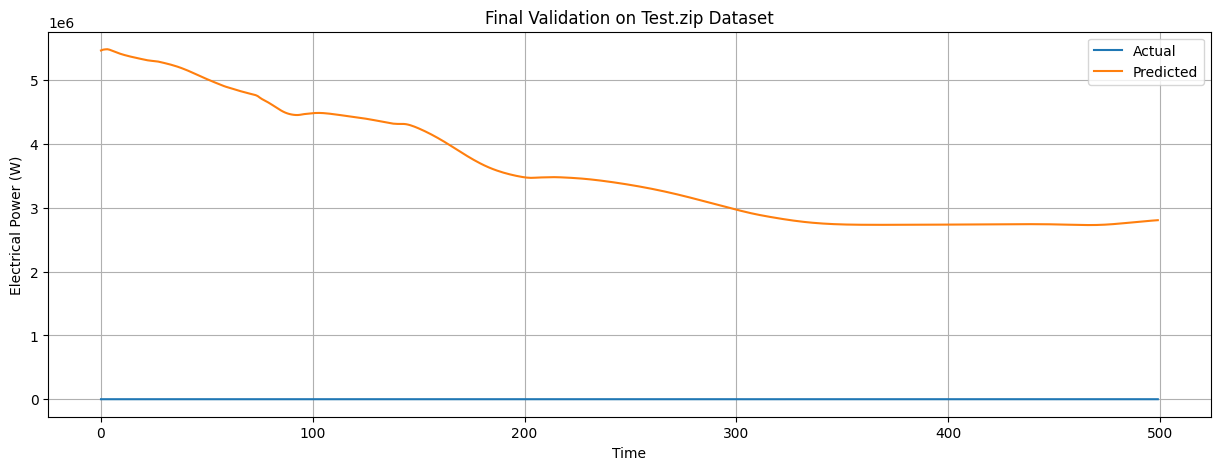

In [13]:
plt.figure(figsize=(15,5))
plt.plot(y_test_final_rescaled[:500], label='Actual')
plt.plot(y_pred_final_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Final Validation on Test.zip Dataset")
plt.xlabel("Time")
plt.ylabel("Electrical Power (W)")
plt.grid()
plt.show()

In [14]:
# Combine y_train and y_test_final before scaling
combined_y = np.concatenate([y_train, y_test_final])

scaler = MinMaxScaler()
scaler.fit(combined_y.reshape(-1,1))

# Re-scale both
y_train_scaled = scaler.transform(y_train.reshape(-1,1))
y_test_final_scaled = scaler.transform(y_test_final.reshape(-1,1))


In [15]:
y_pred_final_scaled = model_mc.predict(X_test_final)

NameError: name 'model_mc' is not defined